# DATA PROCESSING AND FEATURE CREATION

In [396]:
import json
import pandas as pd
import numpy as np
import os, sys
import yaml

%load_ext autoreload
%autoreload 2

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
import src.data_management as my_dm
from src.feature_creation import create_features, create_essentials_features, low_variance_features
seed=456

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [397]:
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

train_file_path = config["data"]["input_train_path"]
test_file_path = config["data"]["input_test_path"]

train_data = []

print(f"Loading data from '{train_file_path}'...")
try:
    with open(train_file_path, 'r') as f:
        for line in f:
            # json.loads() parses one line (one JSON object) into a Python dictionary
            train_data.append(json.loads(line))

    print(f"Successfully loaded {len(train_data)} battles.")

except FileNotFoundError:
    print(f"ERROR: Could not find the training file at '{train_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")

Loading data from '../data/train/raw/train.jsonl'...
Successfully loaded 9999 battles.


In [398]:

# Create feature DataFrames for both training and test sets
print("Processing training data...")
train_df = create_features(train_data)
train_df = train_df.sample(frac=1, random_state=seed).reset_index(drop=True)

### removing correlations
corr_matrix = train_df.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [column for column in upper.columns if any(upper[column] > 0.99) and column!='player_won']  ### overcorrelated features just add no information

train_df = train_df.drop(columns=to_drop)

to_drop2 = low_variance_features(train_df, threshold=1.)  ## constant features just make noyse
train_df = train_df.drop(columns=to_drop2)

print("feature to remove:", to_drop, to_drop2)

print("\nProcessing test data...")
test_data = []
with open(test_file_path, 'r') as f:
    for line in f:
        test_data.append(json.loads(line))
test_df = create_features(test_data)
test_df =test_df.sample(frac=1, random_state=seed).reset_index(drop=True)
## removing correlations in test
test_df = test_df.drop(columns=to_drop)
test_df = test_df.drop(columns=to_drop2)
print("Done")

Processing training data...
feature to remove: ['p1_min_base_def', 'p1_min_base_spd', 'p1_max_base_spd', 'p1_std_base_spd', 'p2_lead_spa', 'p1_max_speed_vs_p2_lead_spe', 'p1_fnt_over_total_pkmn', 'p2_fnt_over_total_pkmn', 'p1-p2_mean_boost_spd', 'p1-p2_switch_number'] ['p1-p2_meta_count']

Processing test data...
Done


In [399]:
corrs = train_df.corrwith(train_df["player_won"])

# print features with |correlation| > 0.5
for feature, corr_value in corrs.items():
    if abs(corr_value) >0.2:
        print(f"{feature}: {corr_value:.3f}")

battle_id: -0.866
player_won: 1.000
p1-p2_total_damage: -0.500
p1-p2_mean_hp_pct: 0.414
hp_adv_last_5_turns: 0.316
p1-p2_total_moves: 0.457
final_debilitating_diff: 0.368
final_non_fnt_status_diff: 0.356
p1_slp_count: -0.319
p2_slp_count: 0.346
p1-p2_slp_count: -0.416
p1_fnt_count: -0.463
p1-p2_fnt_count: -0.486
p2_frz_count: 0.208
p1-p2_frz_count: -0.270
p1-p2_status_difference: 0.592
p1-p2_attack_moves: 0.338
p1-p2_same_type_moves_number: 0.265
health_difference: 0.660
health_advantage_difference: 0.347
remaining_advantage: 0.360
p1-p2_kinetic_threat_diff: 0.516


# MODELS 
This was a different notebook before

In [400]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import yaml
import os

seed=456

In [401]:
features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]

X_train = train_df[features]
X_test=test_df[features]
y_train = train_df['player_won']
#print(features)

X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train,train_size=.8, shuffle=True, random_state=seed)

In [402]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_vali=scaler.transform(X_vali)
X_test = scaler.transform(X_test)
print("(number of data, number of features):",X_train.shape)

(number of data, number of features): (7999, 86)


# Data visualization

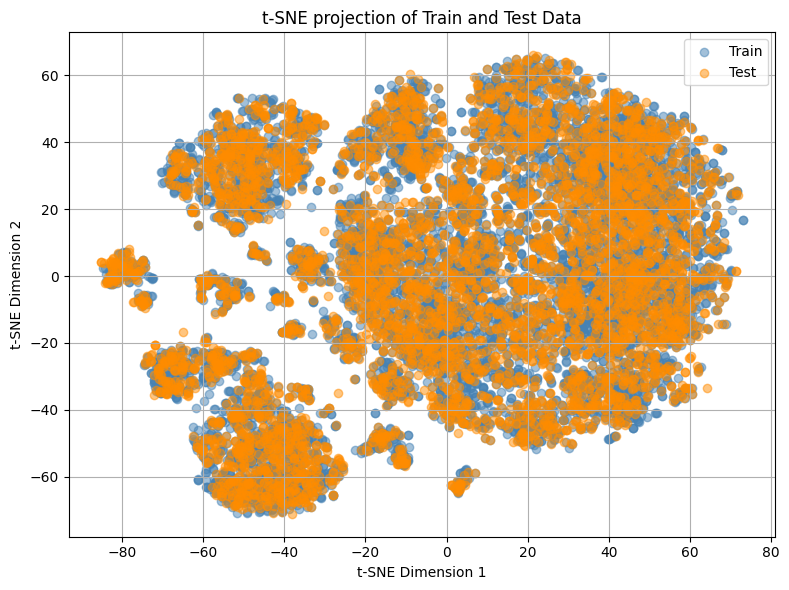

In [403]:


import matplotlib.pyplot as plt
from sklearn.manifold import TSNE



# combining data
X_combined = np.vstack((X_train, X_test))

# Tsne run
tsne = TSNE(
    n_components=2,
    perplexity=30,          
    learning_rate='auto',
    init='pca',
    random_state=seed,
    verbose=False
)

X_combined_tsne = tsne.fit_transform(X_combined)

# Split back into train/test embeddings
X_train_tsne = X_combined_tsne[:len(X_train)]
X_test_tsne = X_combined_tsne[len(X_train):]


plt.figure(figsize=(8, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1],
            alpha=0.5, label='Train', color='steelblue')
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1],
            alpha=0.5, label='Test', color='darkorange')

plt.title("t-SNE projection of Train and Test Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [404]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def print_cm(model, X_train, y_train, X_vali, y_vali, labels=None):

    if labels is None:
        labels = sorted(list(set(y_train) | set(y_vali)))
    
    y_pred_train = model.predict(X_train)
    y_pred_vali = model.predict(X_vali)

    cm_train = confusion_matrix(y_train, y_pred_train, labels=labels)
    cm_vali  = confusion_matrix(y_vali, y_pred_vali, labels=labels)  
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title("Confusion Matrix - TRAIN")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    sns.heatmap(cm_vali, annot=True, fmt="d", cmap="Reds",
                xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title("Confusion Matrix - VALIDATION")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

# Logistic Regression

In [405]:
## GRID SEARCH
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def best_par_lr(X_train, y_train, X_vali, y_vali, param_grid):
    model = LogisticRegression(random_state=seed)

    

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1,
        return_train_score= True
    )

    grid_search.fit(X_train, y_train)
    best_index = grid_search.best_index_
    mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
    std_acc = grid_search.cv_results_['std_test_score'][best_index]

    print(f" Best model mean validation accuracy: {mean_acc:.4f}")
    print(f" Standard deviation across validation folds: {std_acc:.4f}")
    print("Best hyperparameters found:", grid_search.best_params_)
    print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")
    return  grid_search.best_params_

param_grid = {
        'C': [0.1, 0.5, 1,10], 
        'penalty': ['l1','l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [10000]
    }
best_param_lr = best_par_lr(X_train, y_train, X_vali, y_vali, param_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
 Best model mean validation accuracy: 0.8437
 Standard deviation across validation folds: 0.0069
Best hyperparameters found: {'C': 0.5, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy in CV: 0.8437


acc 0.847


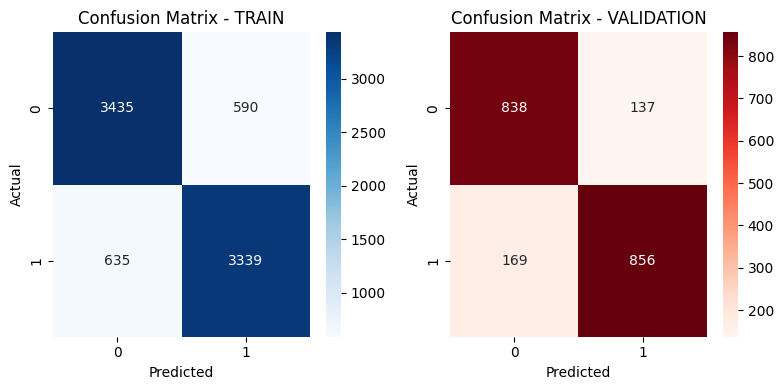

In [406]:
## TRAINING IN THE TRAINING SET
logreg=LogisticRegression(**best_param_lr,random_state=seed)
logreg.fit(X_train,y_train)
y_pred= logreg.predict(X_vali)
logreg_accuracy = accuracy_score(y_vali,y_pred)
print("acc",logreg_accuracy)
best_logreg=logreg
print_cm(best_logreg, X_train, y_train, X_vali, y_vali)

# KNN

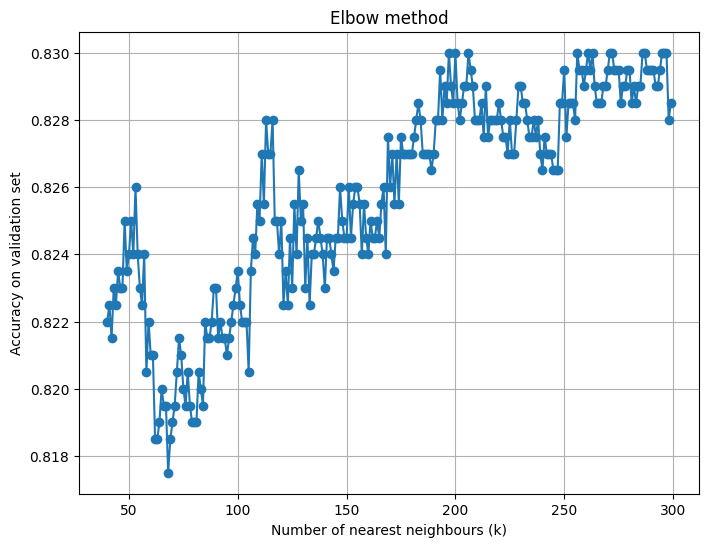

Best k: 197
Accuracy for validation set: 0.8300
 Best model mean validation accuracy: 0.8224
 Standard deviation across validation folds: 0.0034
Best hyperparameters found: {'metric': 'minkowski', 'n_neighbors': 202, 'weights': 'distance'}
Best accuracy in CV: 0.8224


In [407]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

def best_par_knn(X_train, y_train, X_vali, y_vali, param_grid):

    model = KNeighborsClassifier()

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        verbose=False,
        n_jobs=-1
    )


    grid_search.fit(X_train, y_train)
    best_index = grid_search.best_index_
    mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
    std_acc = grid_search.cv_results_['std_test_score'][best_index]

    print(f" Best model mean validation accuracy: {mean_acc:.4f}")
    print(f" Standard deviation across validation folds: {std_acc:.4f}")
    print("Best hyperparameters found:", grid_search.best_params_)
    print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")
    return grid_search.best_params_

k_values = list(range(40,300))
accuracies=[]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_vali)
    acc = accuracy_score(y_vali, y_pred)
    accuracies.append(acc)


plt.figure(figsize=(8,6))
plt.plot(k_values, accuracies, marker='o')
plt.title("Elbow method")
plt.xlabel("Number of nearest neighbours (k)")
plt.ylabel("Accuracy on validation set")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracies)]
print(f"Best k: {best_k}")
print(f"Accuracy for validation set: {max(accuracies):.4f}")
param_grid = {
        'n_neighbors': [best_k-5,best_k, best_k+5],           
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski','manhattan', 'euclidean'],
    }
best_param_knn = best_par_knn(X_train, y_train, X_vali, y_vali, param_grid)

acc 0.8295


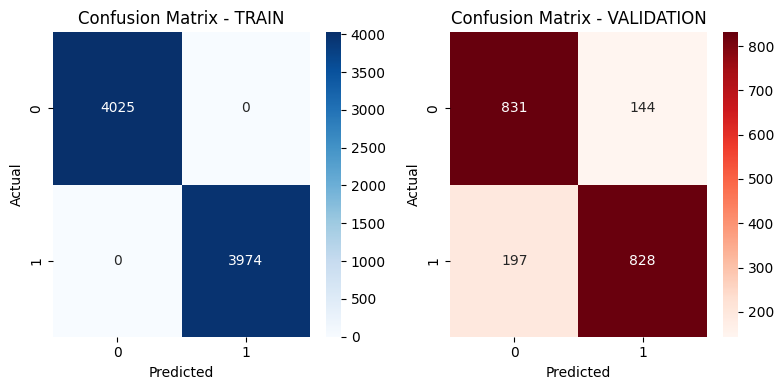

In [408]:
### This is the total knn classifier

best_knn = KNeighborsClassifier(**best_param_knn)
best_knn.fit(X_train, y_train)
y_pred= best_knn.predict(X_vali)
knn_accuracy = accuracy_score(y_vali,y_pred)
print("acc", knn_accuracy)
print_cm(best_knn, X_train, y_train, X_vali, y_vali)

# DECISION TREES


In [409]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score

def best_par_dt(X_train, y_train, X_vali, y_vali, param_grid):
    model = DecisionTreeClassifier(random_state=seed)

    k_range = list(range(60,200,20))



    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=3,
        return_train_score= True
    )

    grid_search.fit(X_train, y_train)
    best_index = grid_search.best_index_
    mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
    std_acc = grid_search.cv_results_['std_test_score'][best_index]

    print(f" Best model mean validation accuracy: {mean_acc:.4f}")
    print(f" Standard deviation across validation folds: {std_acc:.4f}")
    print("Best hyperparameters found:", grid_search.best_params_)
    print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")
    return grid_search.best_params_

param_grid = {
        'criterion': ['gini', 'entropy', 'log_loss'], 
        'max_depth': [3,4,5,6], 
    }
best_param_dt = best_par_dt(X_train, y_train, X_vali, y_vali, param_grid)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Best model mean validation accuracy: 0.8266
 Standard deviation across validation folds: 0.0066
Best hyperparameters found: {'criterion': 'gini', 'max_depth': 4}
Best accuracy in CV: 0.8266


acc 0.8245


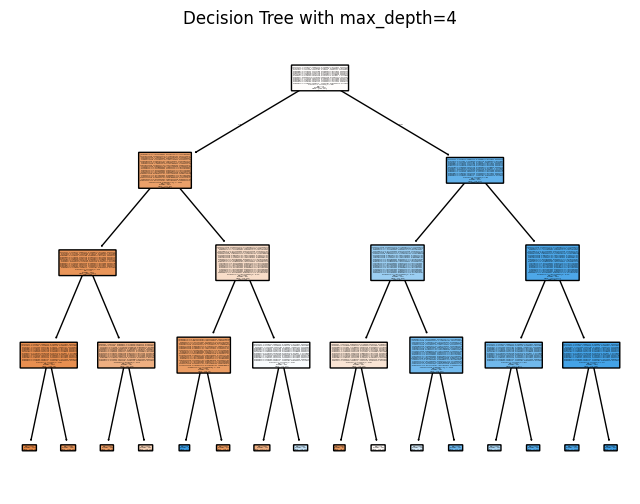

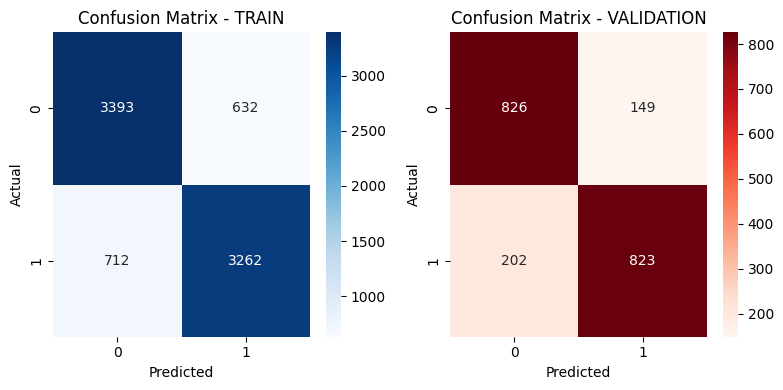

In [410]:
best_dt = DecisionTreeClassifier(**best_param_dt, random_state=seed)
best_dt.fit(X_train, y_train)
y_pred= best_dt.predict(X_vali)
dt_accuracy = accuracy_score(y_vali,y_pred)
print("acc",dt_accuracy)
plt.figure(figsize=(8,6))
plot_tree(best_dt,
          feature_names=X_train,
          class_names=['Lose', 'Win'],   
          filled=True,                   
          rounded=True,                  
          fontsize=1)
plt.title(f"Decision Tree with max_depth={best_param_dt['max_depth']}")
plt.show()
print_cm(best_dt, X_train, y_train, X_vali, y_vali)

# RANDOM FOREST

In [411]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

def best_par_rf(X_train, y_train, X_vali, y_vali, param_grid):
# Define the parameter grid to search over
    
    # Initialize the base model
    rforest = RandomForestClassifier(random_state=seed)

    # Set up K-Fold cross-validation (k=5)
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

    # Set up the Grid Search with cross-validation
    grid_search = GridSearchCV(
        estimator=rforest,
        param_grid=param_grid,
        cv=kfold,
        scoring='accuracy',
        n_jobs=-1,       # use all available CPU cores
        verbose=2
    )

    # Run the grid search
    grid_search.fit(X_train, y_train)

    # Results
    best_index = grid_search.best_index_
    mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
    std_acc = grid_search.cv_results_['std_test_score'][best_index]

    print(f" Best model mean validation accuracy: {mean_acc:.4f}")
    print(f" Standard deviation across validation folds: {std_acc:.4f}")
    print("Best hyperparameters found:", grid_search.best_params_)
    print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")
    return grid_search.best_params_

param_grid = {
        'n_estimators': [250, 300, 350],
        'max_depth': [15, 20, 25],
        'min_samples_leaf': [1],
        'min_samples_split': [2],
        'max_features': ['sqrt'],
        'criterion': ['entropy']
    }

best_param_rf = best_par_rf(X_train, y_train, X_vali, y_vali, param_grid)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
 Best model mean validation accuracy: 0.8374
 Standard deviation across validation folds: 0.0030
Best hyperparameters found: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 350}
Best accuracy in CV: 0.8374


acc 0.8365


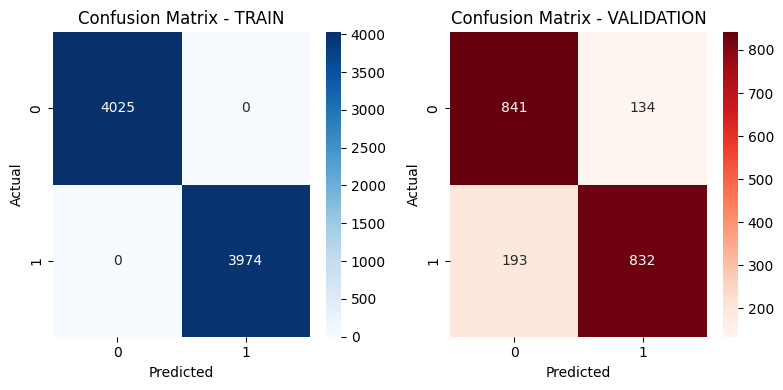

In [412]:
best_rf = RandomForestClassifier(**best_param_rf, random_state=seed)
best_rf.fit(X_train, y_train)
y_pred= best_rf.predict(X_vali)
rf_accuracy = accuracy_score(y_vali,y_pred)
print("acc", rf_accuracy)
print_cm(best_rf, X_train, y_train, X_vali, y_vali)

# XGBOOST


In [413]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV
import numpy as np
import xgboost as xgb
def best_par_xgb(X_train, y_train, X_vali, y_vali, param_grid):
    # Base XGBoost model
    xgb = XGBClassifier(
        random_state=seed,
        use_label_encoder=False,
        eval_metric='logloss'
    )


    # K-Fold cross-validation setup
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

    # Grid Search with cross-validation
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring='accuracy',
        cv=kfold,
        n_jobs=-1,
        verbose=2
    )

    # Run the grid search
    grid_search.fit(X_train, y_train)

    # Results
    best_index = grid_search.best_index_
    mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
    std_acc = grid_search.cv_results_['std_test_score'][best_index]

    print(f" Best model mean validation accuracy: {mean_acc:.4f}")
    print(f" Standard deviation across validation folds: {std_acc:.4f}")
    print("Best hyperparameters found:", grid_search.best_params_)
    print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")
    return grid_search.best_params_

param_grid = {
        'n_estimators': [500, 600, 850, 900],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.005, 0.01, 0.015],
        'gamma': [0],
        'lambda': [1],
        'subsample': [0.8],
        'colsample_bytree': [0.9]
    }
best_param_xgb = best_par_xgb(X_train, y_train, X_vali, y_vali, param_grid)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\franc\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:35:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Best model mean validation accuracy: 0.8447
 Standard deviation across validation folds: 0.0068
Best hyperparameters found: {'colsample_bytree': 0.9, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 850, 'subsample': 0.8}
Best accuracy in CV: 0.8447


acc 0.8500


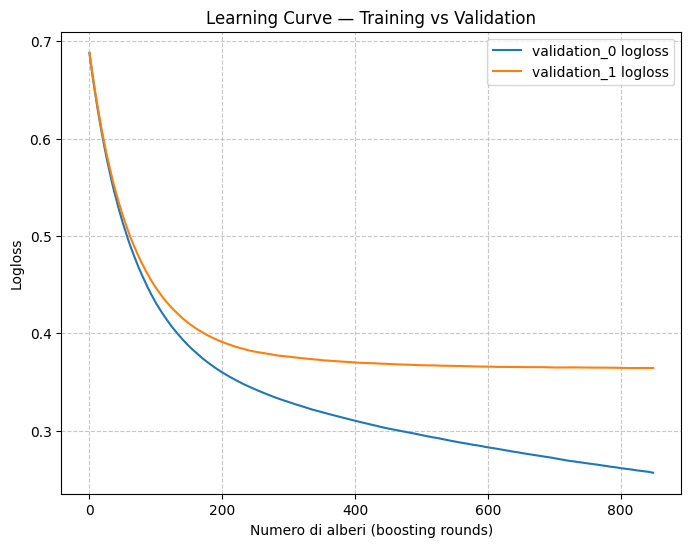

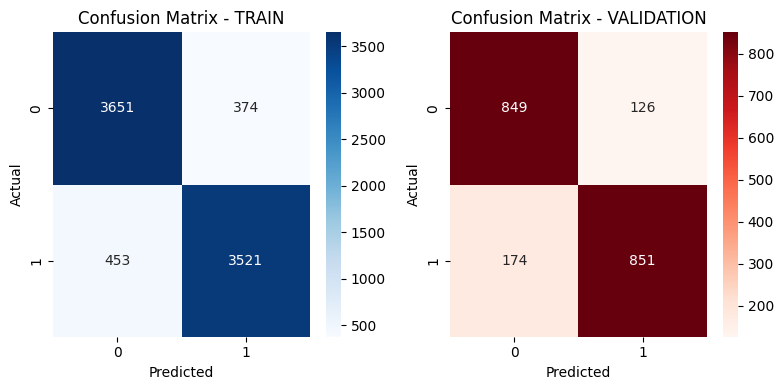

In [414]:
evals_result = {}
best_xgb = XGBClassifier(**best_param_xgb, random_state=seed)
best_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_vali, y_vali)], verbose=False)
y_pred= best_xgb.predict(X_vali)
xgb_accuracy = accuracy_score(y_vali,y_pred)
print(f"acc {xgb_accuracy:.4f}")

evals_result = best_xgb.evals_result()

keys = list(evals_result.keys())
train_key, vali_key = keys[0], keys[1]

train_loss = evals_result[train_key]['logloss']
vali_loss = evals_result[vali_key]['logloss']

# Plot loss
plt.figure(figsize=(8,6))
plt.plot(train_loss, label=f'{train_key} logloss')
plt.plot(vali_loss, label=f'{vali_key} logloss')
plt.xlabel('Numero di alberi (boosting rounds)')
plt.ylabel('Logloss')
plt.title('Learning Curve — Training vs Validation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print_cm(best_xgb, X_train, y_train, X_vali, y_vali)

# ENSEMBLE

Voting ensemble accuracy: 0.8465


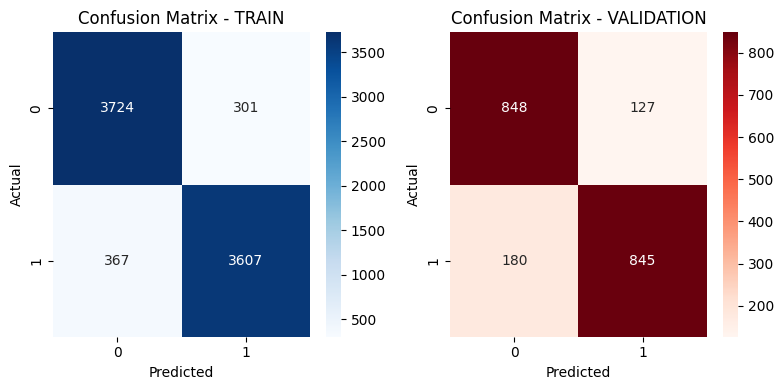

In [415]:
from sklearn.ensemble import VotingClassifier

def voting_class(estimators, X_train, y_train):
    voting = VotingClassifier(
        estimators,
        voting='soft' 
    )

    voting.fit(X_train, y_train)
    return voting
estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('logreg', best_logreg),
        #('knn', best_knn)
    ]
voting = voting_class(estimators, X_train, y_train)
voting_accuracy = voting.score(X_vali, y_vali)
print("Voting ensemble accuracy:", voting_accuracy)
print_cm(voting, X_train, y_train, X_vali, y_vali)

Stacking accuracy: 0.8455


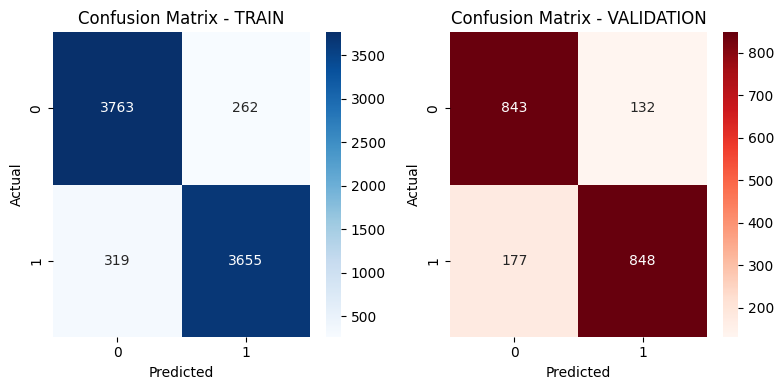

In [416]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Base learners

def stacking_class(estimators, X_train, y_train):
    # Meta-learner
    meta_model = LogisticRegression(random_state=seed, max_iter=100000)

    # Stacking ensemble
    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_model,
        passthrough=True 
    )

    stack.fit(X_train, y_train)
    return stack

estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('logreg', best_logreg),
        #('knn', best_knn)
    ]
stack = stacking_class(estimators, X_train, y_train)
stck_accuracy = stack.score(X_vali, y_vali)
print("Stacking accuracy:", stck_accuracy)
best_stck=stack
print_cm(best_stck, X_train, y_train, X_vali, y_vali)

# FEATURE IMPORTANCE


## Visualizing feature for their importance


RANDOM FOREST
Top 5 most important features:
                     Feature  Importance
0          health_difference    0.133906
1    p1-p2_status_difference    0.081211
2  p1-p2_kinetic_threat_diff    0.056675
3         p1-p2_total_damage    0.043536
4          p1-p2_total_moves    0.037064
Least important 5 features:
                 Feature  Importance
81          p1_brn_count    0.000436
82          p1_psn_count    0.000316
83          p2_brn_count    0.000246
84          p2_psn_count    0.000205
85  p1-p2_mean_boost_def    0.000010


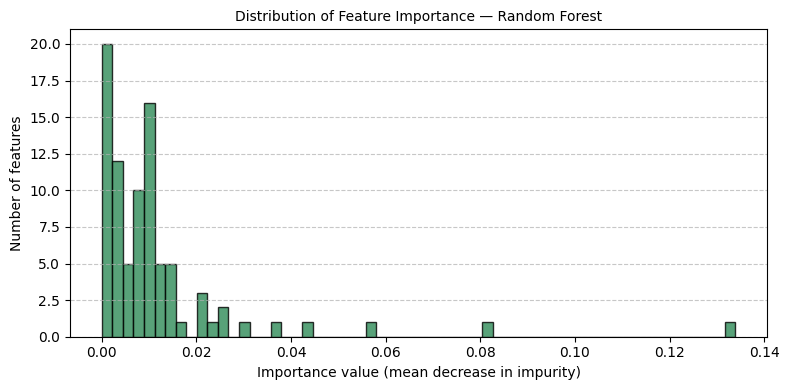

In [417]:
feature_names=[]  ## we put here the features by importance
# We gain the importances
importances = best_rf.feature_importances_

# we create the importance df
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

# we display top and bottom features
print("RANDOM FOREST")
print("Top 5 most important features:")
print(importance_df.head(5))
print("Least important 5 features:")
print(importance_df.tail(5))

# hist of feature importance
plt.figure(figsize=(8, 4))
plt.hist(importance_df["Importance"], bins=60, color="seagreen", edgecolor="black", alpha=0.8)
plt.title("Distribution of Feature Importance — Random Forest", fontsize=10)
plt.xlabel("Importance value (mean decrease in impurity)")
plt.ylabel("Number of features")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
feature_names.append(importance_df['Feature'].tolist())

XGBOOST
Metric: weight
Top 5 most important features:
                      Feature  Importance
80          health_difference      1844.0
40    final_debilitating_diff      1198.0
84  p1-p2_kinetic_threat_diff       824.0
83        remaining_advantage       747.0
64    p1-p2_status_difference       646.0
Least important 5 features:
            Feature  Importance
56     p2_brn_count         5.0
3   p1_min_base_atk         3.0
52     p1_psn_count         3.0
53     p2_psn_count         2.0
54  p1-p2_psn_count         1.0


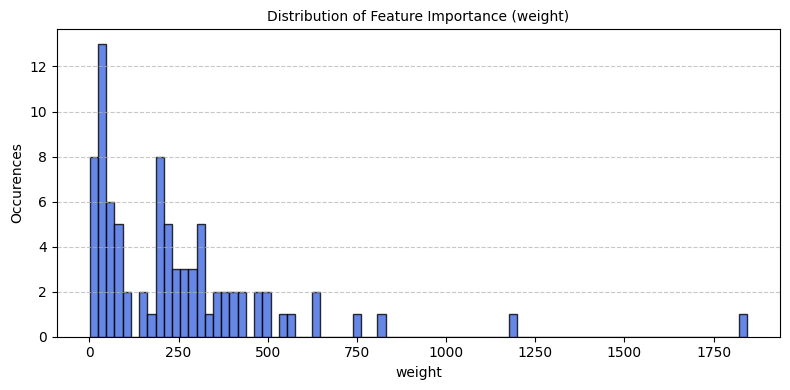

Metric: gain
Top 5 most important features:
                      Feature  Importance
80          health_difference   89.502357
64    p1-p2_status_difference   29.233952
40    final_debilitating_diff   16.570646
42  final_non_fnt_status_diff   15.124875
38          p1-p2_total_moves    9.595904
Least important 5 features:
                    Feature  Importance
11          p1_min_base_spe    4.236770
39  p1-p2_unique_move_types    3.948699
56             p2_brn_count    3.912226
3           p1_min_base_atk    3.411161
53             p2_psn_count    2.731801


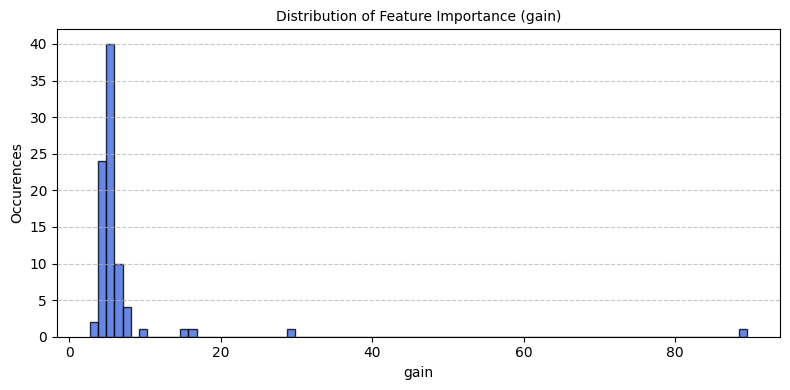

In [418]:
print("XGBOOST")
for i in ['weight', 'gain']:

    # We extract the trained booster from the best XGBoost model
    booster = best_xgb.get_booster()
    # We compute feature importance using gain metric
    importance = booster.get_score(importance_type=i)

    temp_features = []
    for k in importance.keys():
        a = k.strip("f")
        temp_features.append(features[int(a)])


    # We convert to DataFrame and sort by the importance
    importance_df = (
        pd.DataFrame({'Feature': temp_features, 'Importance': list(importance.values())})
        .sort_values(by='Importance', ascending=False)
    )

    # Display the top and bottom features
    print("Metric:",i)
    print("Top 5 most important features:")
    print(importance_df.head(5))

    print("Least important 5 features:")
    print(importance_df.tail(5))

    # Plot of the hist
    plt.figure(figsize=(8, 4))
    if k=='gain':
        plt.hist(importance_df['Importance'], bins=100, color='royalblue', edgecolor='black', alpha=0.8)
    else:
        plt.hist(importance_df['Importance'], bins=80, color='royalblue', edgecolor='black', alpha=0.8)     
    plt.title(f'Distribution of Feature Importance ({i})', fontsize=10)
    plt.xlabel(f'{i}')
    plt.ylabel('Occurences')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Get the ordered list of feature names by importance
    feature_names.append(importance_df['Feature'].tolist())

## Dropping least important features

In [419]:
feature_lists = feature_names

# quantiles in common to remove
quantile = 0.25  
n = len(feature_lists[0])
bottom_n = int(np.ceil(n * quantile))

# Last quantile in sets
bottom_sets = [set(lst[-bottom_n:]) for lst in feature_lists]

# Common features 
common_bottom = set.intersection(*bottom_sets)
print(f"Ultimo {quantile*100:.0f}% = ultimi {bottom_n} elementi per lista\n")
to_drop = list(common_bottom)
print("Candidates to drop:", to_drop)

Ultimo 25% = ultimi 22 elementi per lista

Candidates to drop: ['p2_brn_count', 'p1-p2_psn_count', 'p2_fnt_count', 'p1_min_base_spe', 'p2_psn_count', 'p1_min_base_atk', 'p1_max_base_hp']


In [420]:
not_good=to_drop
not_good.append('battle_id')
not_good.append('player_won')
features = [col for col in train_df.columns if col not in not_good]
X_train_drop = train_df[features]
X_test_drop=test_df[features]
y_train = train_df['player_won']

X_train_drop = scaler.fit_transform(X_train_drop)
X_test_drop = scaler.transform(X_test_drop)

X_train_drop, X_vali_drop, y_train, y_vali = train_test_split(X_train_drop, y_train,train_size=.8, shuffle=True, random_state=seed)
print(X_vali.shape, X_vali_drop.shape)


(2000, 86) (2000, 79)


## Retuning models with gridsearch

We want to see if models perform better if we drop the least important features.
In order to do that we make another gridsearch and then we train in a stack

In [422]:
param_grid = {
        'C': [ 0.13, 0.12, 0.14, 0.11], 
        'penalty': ['l1','l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [10000]
    }
best_param_lr2 = best_par_lr(X_train_drop, y_train, X_vali_drop, y_vali, param_grid)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
 Best model mean validation accuracy: 0.8439
 Standard deviation across validation folds: 0.0062
Best hyperparameters found: {'C': 0.13, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy in CV: 0.8439


In [426]:

param_grid = {
        'n_estimators': [450, 350, 400],
        'max_depth': [14, 16, 15],
        'min_samples_leaf': [1],
        'min_samples_split': [2],
        'max_features': ['sqrt'],
        'criterion': ['entropy']
    }

best_param_rf2 = best_par_rf(X_train_drop, y_train, X_vali_drop, y_vali, param_grid)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
 Best model mean validation accuracy: 0.8381
 Standard deviation across validation folds: 0.0048
Best hyperparameters found: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 350}
Best accuracy in CV: 0.8381


In [429]:
param_grid = {
        'n_estimators': [1150, 1100, 1000, 1200],
        'max_depth': [3, 4, 5],
        'learning_rate': [ 0.01, 0.012, 0.008],
        'gamma': [0],
        'lambda': [1],
        'subsample': [0.8],
        'colsample_bytree': [0.9]
    }
best_param_xgb2 = best_par_xgb(X_train_drop, y_train, X_vali_drop, y_vali, param_grid)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\franc\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:48:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Best model mean validation accuracy: 0.8447
 Standard deviation across validation folds: 0.0088
Best hyperparameters found: {'colsample_bytree': 0.9, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1200, 'subsample': 0.8}
Best accuracy in CV: 0.8447


Stacking accuracy: 0.8475


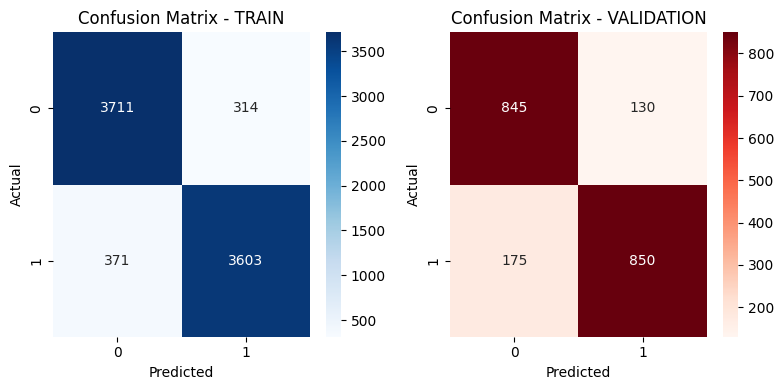

In [430]:
lr2=LogisticRegression(**best_param_lr2,random_state=seed)
xgb2=XGBClassifier(**best_param_xgb2, eval_metric="logloss", random_state=seed)
rf2=RandomForestClassifier(**best_param_rf2,random_state=seed)
estimators=[
        ('rf', rf2),
        ('xgb', xgb2),
        ('logreg', lr2)
    ]
stack2 = stacking_class(estimators, X_train_drop, y_train)
stck2_accuracy = stack2.score(X_vali_drop, y_vali)
print("Stacking accuracy:", stck2_accuracy)

print_cm(stack2, X_train_drop, y_train, X_vali_drop, y_vali)

# DATA SHOWDOWN

In [431]:
model_dict = {
    "LogisticRegression":[best_logreg, logreg_accuracy],
    "KNN":[best_knn, knn_accuracy],
    "DecisionTree":[best_dt, dt_accuracy],
    "RandomForest":[best_rf, rf_accuracy],
    "XGBoost":[best_xgb, xgb_accuracy],
    "Voting":[voting,voting_accuracy],
    "Stacking":[best_stck, stck_accuracy],
    "Stacking after feature drop":[stack2, stck2_accuracy]
}

max_acc = 0
best_model = None
print(f"{'Model:':<20} {'Accuracy:'}")
for model_name, model in model_dict.items():
    if model[1] > max_acc:
        best_model = model[0]
        max_acc = model[1]
    print(f"{model_name:<20} {model[1]}")


Model:               Accuracy:
LogisticRegression   0.847
KNN                  0.8295
DecisionTree         0.8245
RandomForest         0.8365
XGBoost              0.85
Voting               0.8465
Stacking             0.8455
Stacking after feature drop 0.8475


# SUBMISSIONS


In [432]:
#best_model=best_stck
#best_model=stack2
#best_model=best_xgb
#best_model=best_logreg

In [433]:
X_full = train_df[features]  ## feature are the new features with the drops
y_full = train_df['player_won']
X_full_scaled = scaler.fit_transform(X_full)
X_test_full = test_df[features]
X_test_full_scaled = scaler.transform(X_test_full)


final_rf = rf2
final_xgb = xgb2
final_logreg = lr2
#final_knn = KNeighborsClassifier(**best_param_knn)

print("Initiallization")
final_estimators = [
    ('rf', final_rf),
    ('xgb', final_xgb),
    ('logreg', final_logreg),
    #('knn', final_knn)
]

final_meta_model = LogisticRegression(random_state=seed, max_iter=10000000)

final_stack = StackingClassifier(
    estimators=final_estimators,
    final_estimator=final_meta_model,
    passthrough=True,
    cv=5, 
    n_jobs=-1
)

print("Training on all the data our stack")
final_stack.fit(X_full_scaled, y_full)
print("Done!")

Initiallization
Training on all the data our stack
Done!


In [434]:
best_model=final_stack
#best_model=final_lr

In [435]:
# Testing the prediction on the test set

print("Generating predictions on the test set...")
test_predictions = best_model.predict(X_test_full_scaled)

Generating predictions on the test set...


In [436]:

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    'player_won': test_predictions
})
# Save the DataFrame to a .csv file
submission_df.to_csv(output_path, index=False)

print("\n'submission.csv' file created successfully!")


'submission.csv' file created successfully!
